In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
import numpy as np

In [2]:
import yaml

In [3]:
import os 

os.chdir('E://bond-dex/bond-amm-simulation/')

In [4]:
from simulation.__NaiveTradeSimulator import NaiveTradeSimulator

In [5]:
from scripts.generate_stats_v1 import plot_stats

## Trade behaviour

In [16]:
trade_df = pd.read_csv('sources/input/actor_trade/single_trade.csv')

In [17]:
trade_df.head()

,timestamp,action,cash_volume
0,1,borrow,0.002636
1,2,borrow,0.004011
2,3,borrow,0.002832
3,4,borrow,0.000882
4,5,lend,0.000994


In [18]:
trade_df.cash_volume /= 4

In [111]:
LENGTH = 24 * 60

In [112]:
trade_df['day'] = (trade_df.timestamp / LENGTH).astype('int') * LENGTH
trade_df['net_volume'] = trade_df.apply(lambda row: row['cash_volume'] if row['action'] == 'lend'
                                                       else -row['cash_volume'], axis=1)

In [113]:
trade_df = trade_df[trade_df.day < 180 * LENGTH]

In [114]:
agg_trade = trade_df.groupby(['day', 'action'], as_index=False).agg({'net_volume': 'sum'})

In [115]:
net_trade = agg_trade.groupby('day', as_index=False).agg({'net_volume': 'sum'})

In [116]:
agg_trade['cum_volume'] = agg_trade.groupby('action')['net_volume'].transform(lambda x: np.cumsum(x))

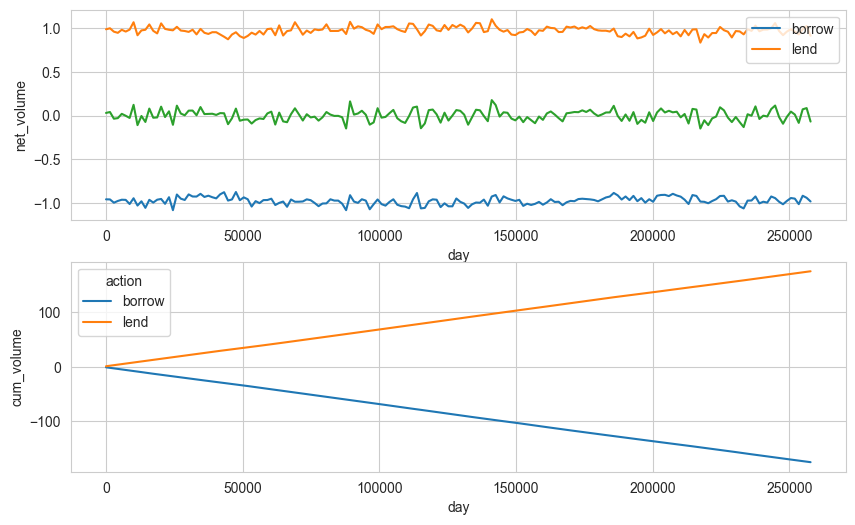

In [117]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

sns.lineplot(data=agg_trade, x='day', y='net_volume', hue='action', 
             ax=axs[0])

sns.lineplot(data=net_trade, x='day', y='net_volume', 
             ax=axs[0])

axs[0].grid(True)

sns.lineplot(data=agg_trade, x='day', y='cum_volume', hue='action', 
             ax=axs[1])
axs[1].grid(True)

plt.show()

## Proposed logit

$p = \frac{X_0}{X_0 + y_0}$

$r = \kappa logit(p) + r^{\star}$

$\alpha = \frac{1}{1 + \tau\kappa}$ 

$B^\star = e^{-r^\star \tau}$

$X_0 = x_0B^\star$

$X_{1}^{\alpha} + y_{1}^{\alpha} = X_{0}^{\alpha} + y_{0}^{\alpha}$

$x_1 = X_{1}B^\star$

In [6]:
_user_defined_func_path = "scripts/price_functions/price_v1.py"

In [7]:
%%writefile {_user_defined_func_path}

import numpy as np
from scipy.special import logit


def calculate_price(x, y, dx, dy, time_to_maturity, maturity_length) -> float:
    tau = time_to_maturity

    r_star = 0.05
    kappa = 0.02

    alpha = 1 / (1 + tau * kappa)
    Br = np.exp(-r_star * tau) 
    
    C = (x * Br) ** alpha + y ** alpha

    if dx != 0:
        new_x = x + dx
        new_y = (C - (Br * new_x) ** alpha) ** (1 / alpha)
        dy = new_y - y
    elif dy != 0:
        new_y = y + dy
        new_x = (C - new_y ** alpha) ** (1 / alpha) / Br
        dx = new_x - x

    if abs((x * Br) ** alpha + y ** alpha - ((x + dx) * Br) ** alpha - (y + dy) ** alpha) > 0.00001:
        raise Exception('Something wrong with ODE!')
    
    r0 = r_star * alpha + kappa * alpha * np.log(x / y)
    if abs(logit(x * np.exp(-r0 * tau) / (x * np.exp(-r0 * tau) + y)) * kappa + r_star - r0) > 0.00001:
        raise Exception('R0 not match!')

    if dx == 0 and dy == 0:
        dy = -np.exp(-tau * r0)
        dx = 1

    price = abs(dy / dx)

    return price

Overwriting scripts/price_functions/price_v1.py


In [75]:
%%writefile config/user_defined_v1.yml

version_name: 'v1'

config:
  simulation:
    simulation_length: 525500
    begin_trade_time: 0
    maturity: 525600
    initial_cash: 0.5
    initial_bond: 0.5256355481880121
    bond_burning: 1

  fee:
    rate: .000

  pricing_config:
      pricing_method: 'user-defined'
      params:
        price_function: 'scripts/price_functions/price_v1.py'

  trader:
    trade_data: 'sources/input/actor_trade/single_trade2.csv'

  tracking:
    dir: 'data/tracking/v1.1'

Overwriting config/user_defined_v1.yml


In [76]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
%autoreload 2

from simulation.__NaiveTradeSimulator import NaiveTradeSimulator

In [78]:
with open('config/user_defined_v1.yml') as file:
    metadata = yaml.safe_load(file)

simulator = NaiveTradeSimulator(metadata['config'])
simulator.run()

Initialized simulation!

------------- Begin running simulation -------------


100%|████████████████████████████████████████████████████████████████████████| 525500/525500 [01:08<00:00, 7645.16it/s]


Total_burn: 0

Saving tracking data to data/tracking/v1.1

------------------ Done simulation ------------------


In [79]:
%autoreload 2

from scripts.generate_stats_v1 import plot_stats

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x800 with 0 Axes>

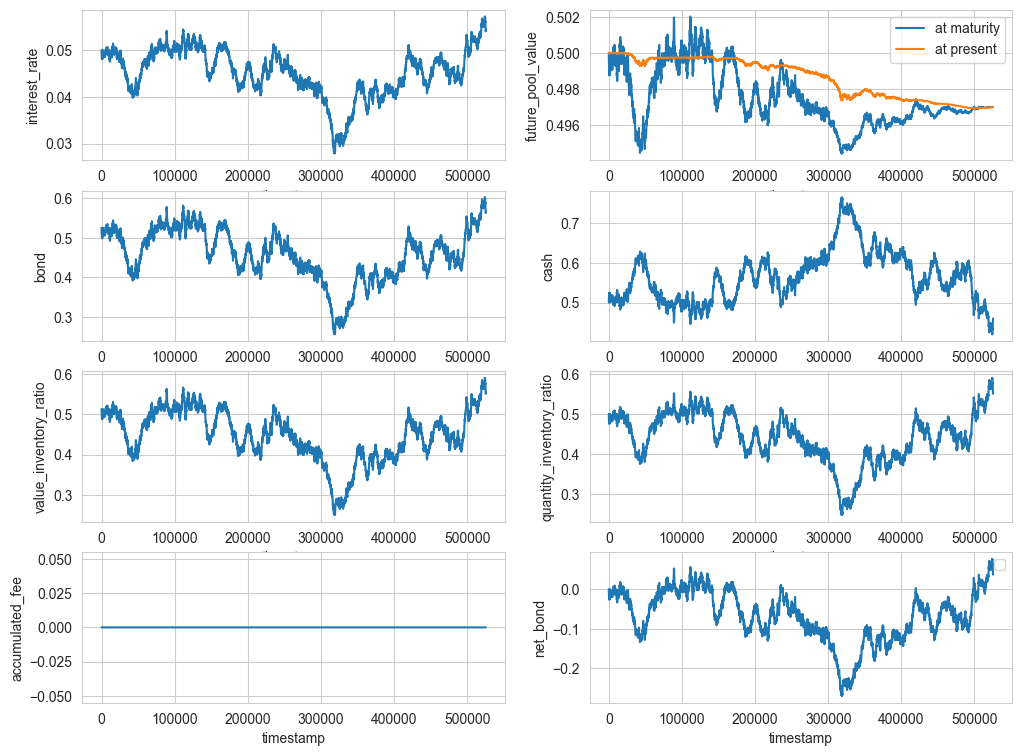

In [80]:
fig = plt.figure(figsize=(10, 8))

plot_stats('data/tracking/v1.1', 'ALL_INFORMATION.json', fig_size=(12, 9))

In [38]:
def lob_density(x, y, tau, kappa, r_star, u):
    
    K = np.exp(-tau * r_star / (1 + tau * kappa))
    alpha = 1 / (1 + tau * kappa)
    
    r0 = kappa * np.log(K*x**(alpha)/y**(alpha)) + r_star
    
    k1 = K**(-1/(tau*kappa)) * np.exp(-r0/kappa)
    
    c1 = y * (np.exp(1/kappa * (r0 - r_star)) + 1)**(tau*kappa + 1)
    c2 = c1**(1/(1 + tau*kappa))

#     dx_du = -c2*(1 + tau*kappa)*k1*(1/(tau*kappa)) \
#             * (K + k1*u**(1/(tau*kappa)))**(-2-tau*kappa) \
#             * u**(1/(tau*kappa)-1)

    density = c2*(1+tau*kappa)/(tau*kappa)*K**(-1/(tau*kappa))*np.exp(-r0/kappa+r0*tau) \
                * (K + K**(-1/(tau*kappa))*np.exp(-r0/kappa)*u**(1/(tau*kappa)))**(-2-tau*kappa) \
                * u**(1/(tau*kappa)-1)
    
    return density

In [39]:
kappa = 0.15
r_star = 0.05

In [40]:
price = np.linspace(0.01, 2, 1000)

In [41]:
x0=1
y0=1 

tau = 0.99 

lob = []

ts = [0.1, 0.5, 0.99, 5, 10]

for tau in ts: 

    lob.append(pd.DataFrame(
        {
            'density': pd.Series(lob_density(x0, y0, tau, kappa, r_star, price)),
            'price': pd.Series(price), 
            'tau': str(tau), 
            'x': x0, 
            'y': y0, 
        }
    )
    )
    
lob = pd.concat(lob)

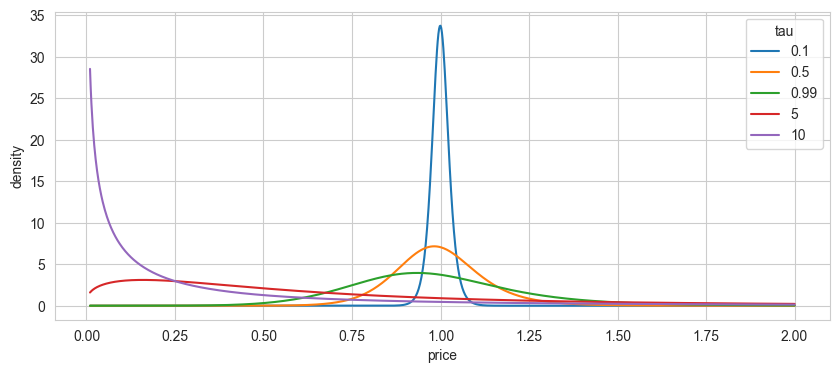

In [42]:
fig, ax = plt.subplots(figsize=(10, 4))

a = sns.lineplot(data=lob, x='price', y='density', hue='tau', palette='tab10')

# for tau, color in zip(ts, sns.color_palette('tab10')): 
#     plt.axvline(np.exp(-r_star * tau), ymin=0, ymax=0.9, color=color, 
#                 linewidth=1, linestyle='dashed')

$$
P_0 = e^{-r0*\tau}
$$

In [40]:
import json


def read_data(folder_dir, file_path):
    file_path = os.path.join(folder_dir, file_path)

    with open(file_path, 'r') as file:
        data = json.load(file)

    _df = pd.DataFrame(data['value'])
    _df['timestamp'] = data['timestamp']
    _df['pool_address'] = data['pool_address']

    return _df

In [41]:
df = read_data('data/tracking/v1.1/', 'ALL_INFORMATION.json')

<Axes: >

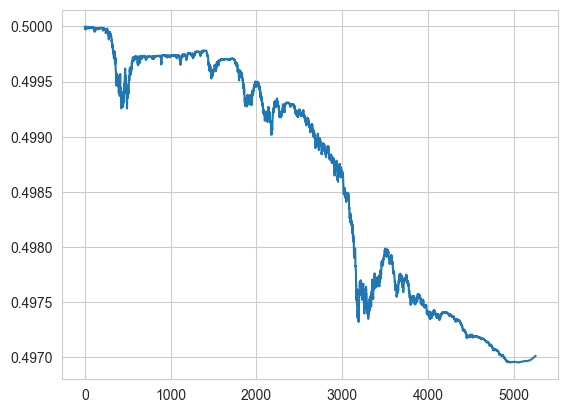

In [42]:
(df.cash + df.net_bond*np.exp(-df.interest_rate*(365*24*60 - df.timestamp)/(365*24*60))).plot()

In [47]:
from scripts.generate_stats_v1 import _make_stats

In [49]:
df = _make_stats(df, 0.5)

In [68]:
df

,cash,bond,net_bond,time_to_maturity,accumulated_fee,interest_rate,timestamp,pool_address,pv_net_bond,pv_bond,pool_value,net_pool_value,future_pool_value,PnL,value_inventory_ratio,quantity_inventory_ratio
0,0.500000,0.525636,-0.000000,525599,0.0,0.050000,1,0xihgvglmtvvndmowdqynhuzsyyzsreo1697990044,-0.000000,0.500000,1.000000,0.500000,0.500000,0.000000,0.512497,0.500000
1,0.508043,0.517178,-0.008453,525499,0.0,0.049369,101,0xihgvglmtvvndmowdqynhuzsyyzsreo1697990044,-0.008045,0.492270,1.000313,0.499997,0.499590,-0.000003,0.504455,0.492116
2,0.511797,0.513230,-0.012396,525399,0.0,0.049075,201,0xihgvglmtvvndmowdqynhuzsyyzsreo1697990044,-0.011802,0.488661,1.000457,0.499994,0.499401,-0.000006,0.500699,0.488437
3,0.516073,0.508735,-0.016886,525299,0.0,0.048739,301,0xihgvglmtvvndmowdqynhuzsyyzsreo1697990044,-0.016083,0.484547,1.000620,0.499990,0.499187,-0.000010,0.496420,0.484247
4,0.516408,0.508378,-0.017238,525199,0.0,0.048713,401,0xihgvglmtvvndmowdqynhuzsyyzsreo1697990044,-0.016419,0.484225,1.000633,0.499989,0.499170,-0.000011,0.496082,0.483919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5250,0.451261,0.551069,0.045752,599,0.0,0.053995,525001,0xihgvglmtvvndmowdqynhuzsyyzsreo1697990044,0.045749,0.551035,1.002296,0.497010,0.497013,-0.002990,0.549788,0.549773
5251,0.453790,0.548534,0.043223,499,0.0,0.053791,525101,0xihgvglmtvvndmowdqynhuzsyyzsreo1697990044,0.043221,0.548506,1.002296,0.497010,0.497013,-0.002990,0.547263,0.547250
5252,0.453729,0.548590,0.043284,399,0.0,0.053796,525201,0xihgvglmtvvndmowdqynhuzsyyzsreo1697990044,0.043282,0.548567,1.002296,0.497011,0.497013,-0.002989,0.547321,0.547311
5253,0.459789,0.542524,0.037224,299,0.0,0.053309,525301,0xihgvglmtvvndmowdqynhuzsyyzsreo1697990044,0.037223,0.542508,1.002296,0.497011,0.497012,-0.002989,0.541272,0.541265


<Axes: >

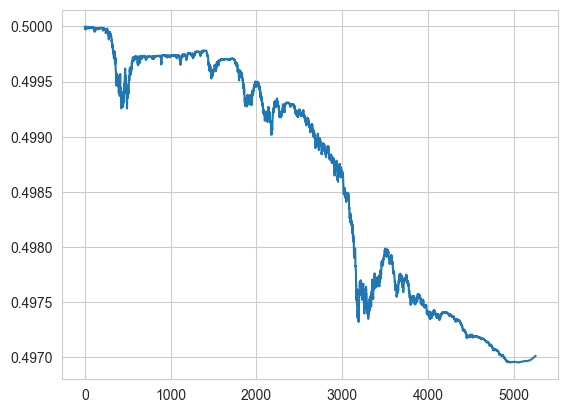

In [67]:
(df.cash + df.net_bond * np.exp(-df.interest_rate * df.time_to_maturity / (365*24*60))).plot()